In [2]:
from dl import queryClient as qc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from functions.dlnpyutils import coords
import functions.parallax as parallax
from astropy.table import Table
import random
from time import perf_counter 
%matplotlib notebook

In [3]:
desdata = Table.read("DES_LT-NSC_DR2-vtan-row_matched.fits", 1)
for i in range(len(desdata)):
    desdata['ID'][i] = desdata['ID'][i].strip()

In [4]:
obj = qc.query(sql='select * from nsc_dr2.hpm where ndet>50 limit 20',fmt='table',profile='db01')
# meas = qc.query(sql="select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='13694_5947'",fmt='table',profile='db01')
#13694_5947

In [5]:
def parallaxplot(idv):
    plt.ion()
    plt.figure()
    tbl = grabdata(idv)
    pars, cov = parallax.fit(tbl)
    parallax.plotfit(tbl,pars, cov)
    plt.suptitle(idv)
    plt.show()

In [6]:
def grabdata(idv):
    dataselect = "select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='" + idv + "'"
    meas = qc.query(sql=dataselect,fmt='table',profile='db01')
    return meas

In [14]:
def plots(idv):
    plt.ion()
    dataselect = "select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='" + idv + "'"
    meas = qc.query(sql=dataselect,fmt='table',profile='db01')
    plt.subplots(2,2, figsize = (9,6))
    plt.subplots_adjust(hspace = .4, wspace = .4)
    plt.suptitle(idv)
    meas["mjd"] -= min(meas["mjd"])
    mjd = (meas["mjd"])+1
    cenra = np.mean(meas["ra"])
    cendec = np.mean(meas["dec"])
    mag = meas["mag_auto"]
    filters = meas["filter"]
    dra, ddec = coords.rotsphcen(meas["ra"], meas["dec"], cenra, cendec, gnomic = True)
    dra = dra*3600
    ddec = ddec*3600
    goodind = np.where(np.logical_and(abs(ddec) < 500, abs(dra) < 500))             
    ddec = ddec[goodind]
    dra = dra[goodind]
    mjd = mjd[goodind]
    filters = filters[goodind]
    mag = mag[goodind]
    
    #radec code
    plt.subplot(2,2,1)
    plt.scatter(dra, ddec, c = mjd, s = 6)
    diffra = max(dra) - min(dra)
    diffdec = max(ddec) - min(ddec)
    plt.xlim(min(dra) - diffra/4, max(dra) + diffra/4)
    plt.ylim(min(ddec) - diffdec/4, max(ddec) + diffdec/4)
    m, b = np.polyfit(dra, ddec, 1)
    plt.plot(dra, m*dra + b, c = "m")
    plt.colorbar()
    plt.xlabel("dra")
    plt.ylabel("ddec")
    
    #ratime
    plt.subplot(2,2,2)
    plt.scatter(mjd, dra, s = 6)
#     plt.errorbar(mjd, dra, yerr = meas["raerr"], ls = "none")
    diffmjd = max(mjd) - min(mjd)
    plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
    plt.ylim(min(dra) - diffra/4, max(dra) + diffra/4)
    m, b = np.polyfit(mjd, dra, 1)
    plt.plot(mjd, m*mjd + b, c = "m")
    plt.xlabel("MJD")
    plt.ylabel("dra")
    
    #dectime
    plt.subplot(2,2,4)
    plt.scatter(mjd, ddec, s = 6)
    plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
    plt.ylim(min(ddec) - diffdec/4, max(ddec) + diffdec/4)
    m, b = np.polyfit(mjd, ddec, 1)
    plt.plot(mjd, m*mjd + b, c = "m")
    plt.xlabel("MJD")
    plt.ylabel("ddec")
    
    #magtime
    plt.subplot(2,2,3)
    count = 0
    colors = ["r", "g", "b", "y", "c"]
    for fil in np.unique(filters):
        filind = np.where(filters == fil)
        plt.scatter(mjd[filind], mag[filind], c = colors[count], label = fil, s = 6)
        count+=1
    plt.legend()
    diffmag = max(mag) - min(mag)
    plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
    plt.ylim(min(mag) - diffmag/4, max(mag) + diffmag/4)
    plt.xlabel("MJD")
    plt.ylabel("MAG")
    
    #parallax
    plt.figure()
    pars, cov = parallax.fit(meas)
    parallax.plotfit(meas,pars, cov)

In [13]:
def plotsave(idv):
    plt.ioff()
    dataselect = "select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='" + idv + "'"
    meas = qc.query(sql=dataselect,fmt='table',profile='db01')
    fig, ax = plt.subplots(5, figsize = (9,28))
    plt.subplots_adjust(hspace = .4, wspace = .2)
    ax[0].set_title(idv)
    meas["mjd"] -= min(meas["mjd"])
    mjd = (meas["mjd"])+1
    cenra = np.mean(meas["ra"])
    cendec = np.mean(meas["dec"])
    mag = meas["mag_auto"]
    filters = meas["filter"]
    dra, ddec = coords.rotsphcen(meas["ra"], meas["dec"], cenra, cendec, gnomic = True)
    dra = dra*3600
    ddec = ddec*3600
    goodind = np.where(np.logical_and(abs(ddec) < 500, abs(dra) < 500))             
    ddec = ddec[goodind]
    dra = dra[goodind]
    mjd = mjd[goodind]
    filters = filters[goodind]
    mag = mag[goodind]
    
    #radec code
    p1 = ax[0].scatter(dra, ddec, c = mjd, s = 6)
    diffra = max(dra) - min(dra)
    diffdec = max(ddec) - min(ddec)
    ax[0].set_xlim(min(dra) - diffra/12, max(dra) + diffra/12)
    ax[0].set_ylim(min(ddec) - diffdec/12, max(ddec) + diffdec/12)
    m, b = np.polyfit(dra, ddec, 1)
    ax[0].plot(dra, m*dra + b, c = "k")
    fig.colorbar(p1, ax = ax[0], orientation = "horizontal")
    ax[0].set_xlabel("dra")
    ax[0].set_ylabel("ddec")
    
    #ratime
    ax[1].scatter(mjd, dra, s = 6)
    diffmjd = max(mjd) - min(mjd)
    ax[1].set_xlim(min(mjd) - diffmjd/16,  max(mjd) + diffmjd/16)
    ax[1].set_ylim(min(dra) - diffra/12, max(dra) + diffra/12)
    m, b = np.polyfit(mjd, dra, 1)
    ax[1].plot(mjd, m*mjd + b, c = "k")
    ax[1].set_xlabel("MJD")
    ax[1].set_ylabel("dra")
    
    #dectime
    ax[2].scatter(mjd, ddec, s = 6)
    ax[2].set_xlim(min(mjd) - diffmjd/16,  max(mjd) + diffmjd/16)
    ax[2].set_ylim(min(ddec) - diffdec/12, max(ddec) + diffdec/12)
    m, b = np.polyfit(mjd, ddec, 1)
    ax[2].plot(mjd, m*mjd + b, c = "k")
    ax[2].set_xlabel("MJD")
    ax[2].set_ylabel("ddec")
    
    #magtime
    count = 0
    colors = ["r", "g", "b", "y", "c", "m", "orange", "pink", "gray", "black", "purple"]
    for fil in np.unique(filters):
        filind = np.where(filters == fil)
        ax[3].scatter(mjd[filind], mag[filind], c = colors[count], label = fil, s = 6)
        count+=1
    ax[3].legend()
    diffmag = max(mag) - min(mag)
    ax[3].set_xlim(min(mjd) - diffmjd/16,  max(mjd) + diffmjd/16)
    ax[3].set_ylim(min(mag) - diffmag/12, max(mag) + diffmag/12)
    ax[3].set_xlabel("MJD")
    ax[3].set_ylabel("MAG")
    
    #parallax
    pars, cov = parallax.fit(meas)
    parallax.plotfit(meas,pars, cov)
    
    #saving
    path = "pictures/"
    picname = idv
    savepng = path+picname
    plt.savefig(savepng, bbox_inches = 'tight')
    plt.close(fig)

In [8]:
def grabids(numberofids = 1):
    n = numberofids
    idlist = []
    for i in range(n):
        idlist.append(desdata["ID"][i])
    return idlist

In [9]:
def findmeanpoints(points, time):
    tpoints = []
    pmean = []
    for p in range(round(float(min(time))), round(float(max(time))+1)):
        l = p - .5
        h = p + .5
        ind, = np.where(np.logical_and(time > l, time < h))
        deer = points[ind]
        meanval = np.mean(deer)
        if meanval == 0:
            pass
        else:
            tpoints.append(p)
            pmean.append(meanval)
    return np.array(tpoints),np.array(pmean)

In [10]:
def randomids(numids = 1):
    ids = []
    for i in range(numids):
        idm = random.choice(desdata["ID"])
        ids.append(idm)
    return ids

In [321]:
# plotstesting("14026_205")

In [49]:
meas = qc.query(sql="select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='100097_7707'",fmt='table',profile='db01')

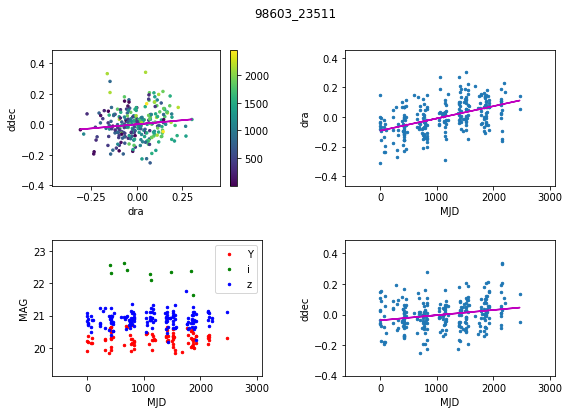

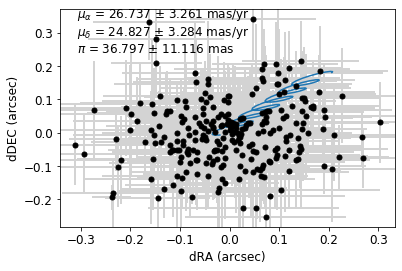

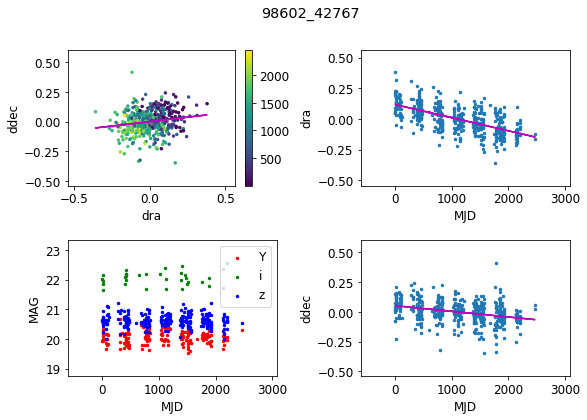

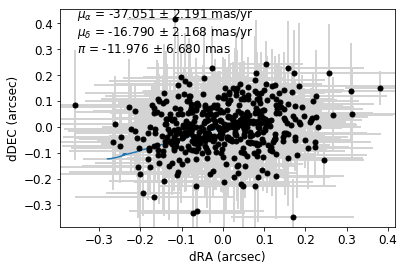

In [15]:
i = grabids(2)
for idd in i:
    plots(idd)

In [235]:
# for i in randomids(5):
#      parallaxplot(i)